## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import datetime
import psycopg2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import datetime as dt

connection = psycopg2.connect(
    host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com",
    database="mid_term_project",
    user="lhl_student",
    password="lhl_student",
    port=5432
)

In [3]:
df_flights = pd.read_sql_query('SELECT * FROM flights ORDER BY RANDOM() LIMIT 50000;', connection)
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-08-24,UA,UA_CODESHARE,UA,5090,OO,N982SW,5090,11292,DEN,...,283.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2019-01-05,WN,WN,WN,3113,WN,N485WN,3113,12191,HOU,...,1020.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
2,2018-05-18,WN,WN,WN,863,WN,N8613K,863,12191,HOU,...,1020.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
3,2018-08-27,DL,DL_CODESHARE,DL,5355,9E,N137EV,5355,14122,PIT,...,726.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
4,2019-05-29,DL,DL,DL,443,DL,N865DN,443,10140,ABQ,...,1269.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None


In [4]:
df_flights.shape

(50000, 42)

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [5]:
df_flights.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

#### **Task 6**: How many states cover 50% of US air traffic? 

In [6]:
feature_traffic=['fl_date', 'mkt_unique_carrier', 'origin', 'origin_city_name', 'dest', 'dest_city_name', 'flights']
# converts to date time format
df_flights['fl_date']=pd.to_datetime(df_flights['fl_date'],format='%Y-%m-%d')

In [7]:
df_flights[feature_traffic].head()

,fl_date,mkt_unique_carrier,origin,origin_city_name,dest,dest_city_name,flights
0,2019-08-24,UA,DEN,"Denver, CO",CNY,"Moab, UT",1.0
1,2019-01-05,WN,HOU,"Houston, TX",PHX,"Phoenix, AZ",1.0
2,2018-05-18,WN,HOU,"Houston, TX",PHX,"Phoenix, AZ",1.0
3,2018-08-27,DL,PIT,"Pittsburgh, PA",MSP,"Minneapolis, MN",1.0
4,2019-05-29,DL,ABQ,"Albuquerque, NM",ATL,"Atlanta, GA",1.0


In [8]:
task6=df_flights[feature_traffic].copy()
task6['origin_state']=task6['origin_city_name'].str[-3:]
task6['dest_state']=task6['dest_city_name'].str[-3:]
task6.head()

,fl_date,mkt_unique_carrier,origin,origin_city_name,dest,dest_city_name,flights,origin_state,dest_state
0,2019-08-24,UA,DEN,"Denver, CO",CNY,"Moab, UT",1.0,CO,UT
1,2019-01-05,WN,HOU,"Houston, TX",PHX,"Phoenix, AZ",1.0,TX,AZ
2,2018-05-18,WN,HOU,"Houston, TX",PHX,"Phoenix, AZ",1.0,TX,AZ
3,2018-08-27,DL,PIT,"Pittsburgh, PA",MSP,"Minneapolis, MN",1.0,PA,MN
4,2019-05-29,DL,ABQ,"Albuquerque, NM",ATL,"Atlanta, GA",1.0,NM,GA


In [9]:
task6_res=pd.DataFrame(task6.groupby(by='origin_state')['flights'].sum().sort_values(ascending=False))
task6_res.columns=['flights_count']
task6_res['flights_count_%']=(task6_res.flights_count/task6_res.flights_count.sum())*100
task6_res['flights_count_%_cum']=task6_res['flights_count_%'].cumsum()
task6_res.head(10)

,flights_count,flights_count_%,flights_count_%_cum
origin_state,,,
CA,5326.0,10.652,10.652
TX,4978.0,9.956,20.608
FL,3756.0,7.512,28.120
IL,3201.0,6.402,34.522
NY,2647.0,5.294,39.816
GA,2636.0,5.272,45.088
NC,2288.0,4.576,49.664
CO,1979.0,3.958,53.622
PA,1478.0,2.956,56.578


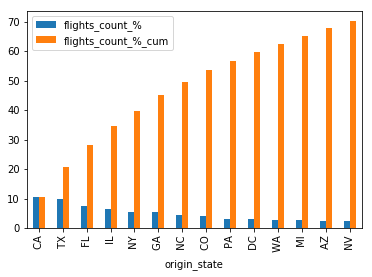

In [11]:
axes=task6_res.iloc[:14,1:].plot.bar()

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [12]:
feature_tsk7=['fl_date','crs_elapsed_time','actual_elapsed_time','dep_delay','taxi_in','taxi_out']

In [13]:
task7=df_flights[feature_tsk7].copy()
task7.head()

,fl_date,crs_elapsed_time,actual_elapsed_time,dep_delay,taxi_in,taxi_out
0,2019-08-24,74.0,65.0,0.0,5.0,16.0
1,2019-01-05,175.0,165.0,-3.0,5.0,7.0
2,2018-05-18,170.0,162.0,21.0,4.0,13.0
3,2018-08-27,132.0,123.0,-7.0,2.0,14.0
4,2019-05-29,188.0,178.0,21.0,5.0,15.0


In [14]:
task7.describe()

,crs_elapsed_time,actual_elapsed_time,dep_delay,taxi_in,taxi_out
count,50000.000000,49030.000000,49176.000000,49123.000000,49146.000000
mean,138.272260,133.674689,11.034854,7.766382,17.555793
std,71.582831,71.587365,50.748028,6.420474,10.081018
min,-35.000000,21.000000,-276.000000,0.000000,1.000000
25%,87.000000,82.000000,-6.000000,4.000000,11.000000
50%,120.000000,115.000000,-2.000000,6.000000,15.000000
75%,168.000000,164.000000,7.000000,9.000000,20.000000
max,690.000000,669.000000,1449.000000,224.000000,169.000000


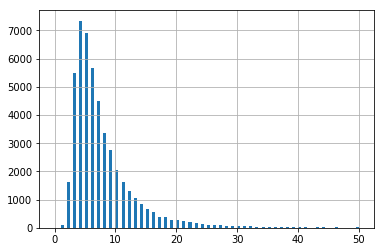

In [15]:
task7.taxi_in.hist(bins=100, range=(0, 50))

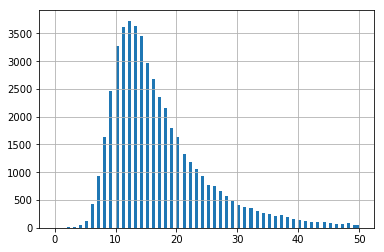

In [16]:
task7.taxi_out.hist(bins=100, range=(0, 50))

In [17]:
# count how many times actual<crs
fast_flight=task7[task7.actual_elapsed_time<task7.crs_elapsed_time].fl_date.count()
fast_flight

34588

In [18]:
fast_flight_withdelay=task7[(task7.actual_elapsed_time<task7.crs_elapsed_time) & (task7.dep_delay>0)].fl_date.count()
fast_flight_withdelay

11653

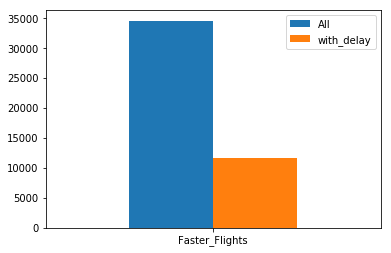

In [19]:
index=['Faster_Flights']
with_delay=[fast_flight_withdelay]
All=[fast_flight]
df_tsk7=pd.DataFrame({'All':All, 'with_delay':with_delay}, index=index)
df_tsk7.plot.bar(rot=0)

### Another approach

In [20]:
feature2_tsk7=['fl_date','crs_elapsed_time','actual_elapsed_time','dep_delay','arr_delay','distance','air_time']

In [21]:
task7_2=df_flights[feature2_tsk7].copy()
task7_2.head()

,fl_date,crs_elapsed_time,actual_elapsed_time,dep_delay,arr_delay,distance,air_time
0,2019-08-24,74.0,65.0,0.0,-9.0,283.0,44.0
1,2019-01-05,175.0,165.0,-3.0,-13.0,1020.0,153.0
2,2018-05-18,170.0,162.0,21.0,13.0,1020.0,145.0
3,2018-08-27,132.0,123.0,-7.0,-16.0,726.0,107.0
4,2019-05-29,188.0,178.0,21.0,11.0,1269.0,158.0


In [22]:
task7_2['distance_km']=task7_2.distance*1.609344
task7_2['air_time_h']=task7_2.air_time*0.01666667
task7_2['speed']=task7_2.distance_km/task7_2.air_time_h
task7_2.head()

,fl_date,crs_elapsed_time,actual_elapsed_time,dep_delay,arr_delay,distance,air_time,distance_km,air_time_h,speed
0,2019-08-24,74.0,65.0,0.0,-9.0,283.0,44.0,455.444352,0.733333,621.060356
1,2019-01-05,175.0,165.0,-3.0,-13.0,1020.0,153.0,1641.530880,2.550001,643.737471
2,2018-05-18,170.0,162.0,21.0,13.0,1020.0,145.0,1641.530880,2.416667,679.254021
3,2018-08-27,132.0,123.0,-7.0,-16.0,726.0,107.0,1168.383744,1.783334,655.168324
4,2019-05-29,188.0,178.0,21.0,11.0,1269.0,158.0,2042.257536,2.633334,775.540681


In [23]:
task7_2[task7_2.dep_delay<=0].speed.mean()

637.2405679603222

In [24]:
task7_2[task7_2.dep_delay>0].speed.mean()

652.0680562597877

In [25]:
# count how many times actual<crs
fast_flight2=task7_2[(task7_2.actual_elapsed_time<task7_2.crs_elapsed_time)& (task7.dep_delay<=0)].speed.mean()
fast_flight2

650.8190440551599

In [26]:
fast_flight2=task7_2[(task7.actual_elapsed_time<task7.crs_elapsed_time) & (task7.dep_delay>0)].speed.mean()
fast_flight2

668.9131792676523

### Another approach, used as final result

In [27]:
task7_3=df_flights[feature2_tsk7].copy()
task7_3

,fl_date,crs_elapsed_time,actual_elapsed_time,dep_delay,arr_delay,distance,air_time
0,2019-08-24,74.0,65.0,0.0,-9.0,283.0,44.0
1,2019-01-05,175.0,165.0,-3.0,-13.0,1020.0,153.0
2,2018-05-18,170.0,162.0,21.0,13.0,1020.0,145.0
3,2018-08-27,132.0,123.0,-7.0,-16.0,726.0,107.0
4,2019-05-29,188.0,178.0,21.0,11.0,1269.0,158.0
...,...,...,...,...,...,...,...
49995,2018-03-08,138.0,120.0,-9.0,-27.0,872.0,102.0
49996,2018-01-28,180.0,186.0,2.0,8.0,1246.0,164.0
49997,2018-04-27,121.0,108.0,-8.0,-21.0,601.0,86.0
49998,2019-08-28,81.0,71.0,-7.0,-17.0,184.0,32.0


In [28]:
flights_dep_delayed=task7_3[task7_3.dep_delay>0].fl_date.count()
flights_dep_delayed

16732

In [30]:
# flights with arr_delay smaller than the dep_delay
flights_reduce_delay=task7_3[(task7_3.dep_delay>0)&(task7_3.arr_delay<task7_3.dep_delay)].fl_date.count()
flights_reduce_delay

11650

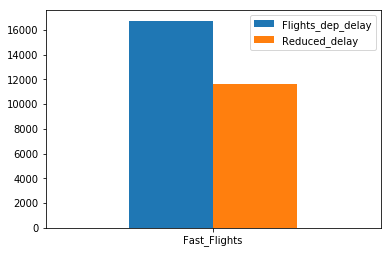

In [31]:
index=['Fast_Flights']
with_delay=[flights_dep_delayed]
reduced_delay=[flights_reduce_delay]
df_tsk7_3=pd.DataFrame({'Flights_dep_delay':with_delay, 'Reduced_delay':reduced_delay}, index=index)
df_tsk7_3.plot.bar(rot=0)

In [32]:
task7_3['distance_km']=task7_3.distance*1.609344
task7_3['air_time_h']=task7_3.air_time*0.01666667
task7_3['speed']=task7_3.distance_km/task7_3.air_time_h
task7_3.head()

,fl_date,crs_elapsed_time,actual_elapsed_time,dep_delay,arr_delay,distance,air_time,distance_km,air_time_h,speed
0,2019-08-24,74.0,65.0,0.0,-9.0,283.0,44.0,455.444352,0.733333,621.060356
1,2019-01-05,175.0,165.0,-3.0,-13.0,1020.0,153.0,1641.530880,2.550001,643.737471
2,2018-05-18,170.0,162.0,21.0,13.0,1020.0,145.0,1641.530880,2.416667,679.254021
3,2018-08-27,132.0,123.0,-7.0,-16.0,726.0,107.0,1168.383744,1.783334,655.168324
4,2019-05-29,188.0,178.0,21.0,11.0,1269.0,158.0,2042.257536,2.633334,775.540681


In [33]:
task7_3[task7_3.dep_delay<=0].speed.mean()

637.2405679603222

In [34]:
task7_3[task7_3.dep_delay>0].speed.mean()

652.0680562597877

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [36]:
#  CRS Elapsed Time of Flight, in Minutes
#  CRS Departure Time (local time
task8=df_flights[['crs_elapsed_time', 'crs_dep_time']].copy()
task8['crs_dep_time_h']=task8.crs_dep_time//100
task8.head()

,crs_elapsed_time,crs_dep_time,crs_dep_time_h
0,74.0,1600,16
1,175.0,645,6
2,170.0,2230,22
3,132.0,1236,12
4,188.0,1400,14


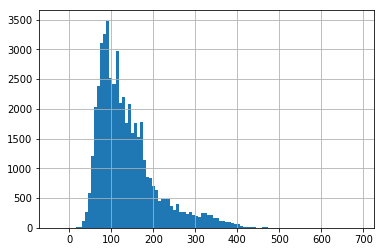

In [37]:
task8.crs_elapsed_time.hist(bins=100) #, range=(0, 500))

In [38]:
def get_flight_length(x):
    if x < 180:
        return 'short'
    elif x > 360:
        return 'long'
    else:
        return 'medium'

In [39]:
### ADD FEATURE ###
task8['haul'] = task8['crs_elapsed_time'].apply(get_flight_length)
task8.head()

,crs_elapsed_time,crs_dep_time,crs_dep_time_h,haul
0,74.0,1600,16,short
1,175.0,645,6,short
2,170.0,2230,22,short
3,132.0,1236,12,short
4,188.0,1400,14,medium


In [40]:
haul=pd.DataFrame(task8.groupby(['crs_dep_time_h','haul']).size()).reset_index()
haul.columns=['crs_dep_time_h','haul','count']
haul

,crs_dep_time_h,haul,count
0,0,medium,72
1,0,short,18
2,1,medium,30
3,1,short,12
4,2,medium,9
...,...,...,...
62,22,medium,244
63,22,short,1076
64,23,long,2
65,23,medium,241


In [41]:
haul=haul.set_index('crs_dep_time_h')
haul=haul.pivot(index=haul.index, columns='haul')['count']
haul

haul,long,medium,short
crs_dep_time_h,,,
0,NaN,72.0,18.0
1,NaN,30.0,12.0
2,NaN,9.0,5.0
3,NaN,4.0,4.0
4,NaN,2.0,1.0
5,5.0,143.0,1038.0
6,27.0,672.0,2873.0
7,69.0,796.0,2617.0
8,62.0,705.0,2496.0


In [42]:
# change the order of the columns
haul=haul.reindex(columns=['short','medium','long'])
haul

haul,short,medium,long
crs_dep_time_h,,,
0,18.0,72.0,NaN
1,12.0,30.0,NaN
2,5.0,9.0,NaN
3,4.0,4.0,NaN
4,1.0,2.0,NaN
5,1038.0,143.0,5.0
6,2873.0,672.0,27.0
7,2617.0,796.0,69.0
8,2496.0,705.0,62.0


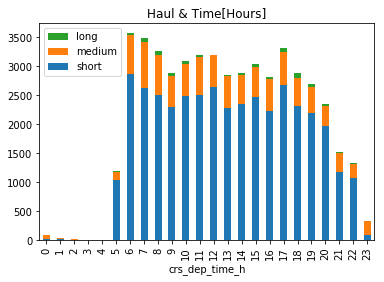

In [47]:

ax=haul.plot(kind='bar',stacked=True)
pl.title('Haul & Time[Hours]')
#plt.legend()
handles,labels = ax.get_legend_handles_labels()
handles=[handles[2],handles[1],handles[0]]
labels=[labels[2],labels[1],labels[0]]
ax.legend(handles,labels,loc=2)
pl.show()

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [48]:
df_airport_passengers = pd.read_sql_query('SELECT origin, origin_airport_id, origin_city_name, dest, dest_airport_id,dest_city_name, passengers FROM passengers ORDER BY RANDOM() LIMIT 50000;', connection)
df_airport_passengers.head()

,origin,origin_airport_id,origin_city_name,dest,dest_airport_id,dest_city_name,passengers
0,FAI,11630,"Fairbanks, AK",TAL,15124,"Tanana, AK",10.0
1,BRO,10747,"Brownsville, TX",PTK,14275,"Pontiac, MI",0.0
2,CAE,10868,"Columbia, SC",IAD,12264,"Washington, DC",2270.0
3,SFO,14771,"San Francisco, CA",MSY,13495,"New Orleans, LA",1772.0
4,JFK,12478,"New York, NY",ORD,13930,"Chicago, IL",0.0


Traffic by airport id

In [56]:
task9=df_flights[['fl_date', 'origin_city_name','origin_airport_id', 'dest_airport_id', 'flights']].copy()
task9.head

<bound method NDFrame.head of          fl_date origin_city_name  origin_airport_id  dest_airport_id  flights
0     2019-08-24       Denver, CO              11292            11092      1.0
1     2019-01-05      Houston, TX              12191            14107      1.0
2     2018-05-18      Houston, TX              12191            14107      1.0
3     2018-08-27   Pittsburgh, PA              14122            13487      1.0
4     2019-05-29  Albuquerque, NM              10140            10397      1.0
...          ...              ...                ...              ...      ...
49995 2018-03-08      Phoenix, AZ              14107            10423      1.0
49996 2018-01-28  Los Angeles, CA              12892            11259      1.0
49997 2018-04-27       Tucson, AZ              15376            14869      1.0
49998 2019-08-28     New York, NY              12953            10721      1.0
49999 2018-06-06  Minneapolis, MN              13487            12266      1.0

[50000 rows x 5 colum

In [50]:
airport_id_o=pd.DataFrame(task9.groupby(['origin_airport_id','origin_city_name']).flights.count().sort_values(ascending=False))
airport_id_o.columns=['flights_o']
airport_id_o.reset_index(level=1,inplace=True)
len(airport_id_o)

365

In [55]:
airport_id_o

,origin_city_name,flights_o
origin_airport_id,,
13930,"Chicago, IL",2504
10397,"Atlanta, GA",2485
11298,"Dallas/Fort Worth, TX",1812
11292,"Denver, CO",1768
11057,"Charlotte, NC",1557
...,...,...
14222,"Pago Pago, TT",1
14905,"Santa Maria, CA",1
11997,"Gustavus, AK",1


In [57]:
airport_id_d=pd.DataFrame(task9.groupby('dest_airport_id').flights.count().sort_values(ascending=False))
airport_id_d.columns=['flights_d']
len(airport_id_d)

362

In [58]:
airport_id_d

,flights_d
dest_airport_id,
13930,2485
10397,2450
11298,1832
11292,1712
12892,1631
...,...
11867,1
14259,1
12250,1


In [53]:
df_passenger=pd.DataFrame(df_airport_passengers.groupby(['origin_airport_id','origin_city_name']).passengers.sum().sort_values(ascending=False))
df_passenger.reset_index(level=1,inplace=True)
df_passenger

,origin_city_name,passengers
origin_airport_id,,
10397,"Atlanta, GA",5314523.0
12892,"Los Angeles, CA",4376757.0
13930,"Chicago, IL",4186308.0
11298,"Dallas/Fort Worth, TX",3577327.0
14771,"San Francisco, CA",3118530.0
...,...,...
14533,"Riverside, CA",0.0
14467,"Roseburg, OR",0.0
14431,"Window Rock, AZ",0.0


In [71]:
df_airport_id=pd.merge(airport_id_o,airport_id_d,right_index=True, left_index=True)
df_airport_id['flights']=df_airport_id['flights_o']+df_airport_id['flights_d']
df_airport_id['flights_perc']=(df_airport_id['flights']/df_airport_id['flights'].sum())*100
df_airport_id['flights_perc_cum']=df_airport_id['flights_perc'].cumsum()
df_airport_id=pd.merge(df_airport_id,df_passenger.passengers,right_index=True, left_index=True)
df_airport_id['passengers_perc']=(df_airport_id['passengers']/df_airport_id['passengers'].sum())*100
df_airport_id

,origin_city_name,flights_o,flights_d,flights,flights_perc,flights_perc_cum,passengers,passengers_perc
13930,"Chicago, IL",2504,2485,4989,4.989998,4.989998,4186308.0,4.502745
10397,"Atlanta, GA",2485,2450,4935,4.935987,9.925985,5314523.0,5.716240
11298,"Dallas/Fort Worth, TX",1812,1832,3644,3.644729,13.570714,3577327.0,3.847732
11292,"Denver, CO",1768,1712,3480,3.480696,17.051410,3113973.0,3.349354
11057,"Charlotte, NC",1557,1615,3172,3.172635,20.224045,2328294.0,2.504286
...,...,...,...,...,...,...,...,...
11468,"Kearney, NE",1,1,2,0.002000,99.984997,1353.0,0.001455
13832,"Ogdensburg, NY",1,1,2,0.002000,99.986997,1729.0,0.001860
13873,"Nome, AK",1,5,6,0.006001,99.992999,10636.0,0.011440
14905,"Santa Maria, CA",1,1,2,0.002000,99.994999,6825.0,0.007341


In [68]:
df_airport_id.sort_values(by='passengers',ascending=False)

,origin_city_name,flights_o,flights_d,flights,flights_perc,passengers,passengers_perc
10397,"Atlanta, GA",2485,2450,4935,4.935987,5314523.0,5.716240
12892,"Los Angeles, CA",1533,1631,3164,3.164633,4376757.0,4.707589
13930,"Chicago, IL",2504,2485,4989,4.989998,4186308.0,4.502745
11298,"Dallas/Fort Worth, TX",1812,1832,3644,3.644729,3577327.0,3.847732
14771,"San Francisco, CA",1102,1111,2213,2.213443,3118530.0,3.354255
...,...,...,...,...,...,...,...
14520,"Rhinelander, WI",5,6,11,0.011002,13.0,0.000014
14150,"Pellston, MI",7,7,14,0.014003,11.0,0.000012
11470,"Wenatchee, WA",12,3,15,0.015003,4.0,0.000004
10268,"Waterloo, IA",3,1,4,0.004001,0.0,0.000000


Text(0.5,1,'Flight Traffic & Passanger Traffic')

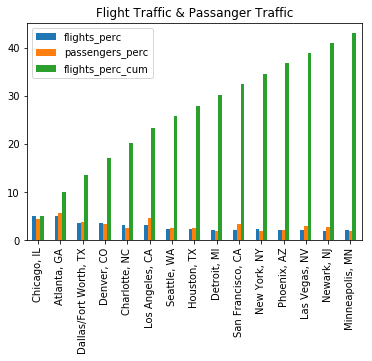

In [72]:
nvar=15
xlabel_list=df_airport_id.origin_city_name.values.tolist()[:nvar]
#xlabel_list
axes=df_airport_id[['flights_perc','passengers_perc','flights_perc_cum']].iloc[:nvar,:].plot.bar()
axes.set_xticklabels((xlabel_list))
axes.set_title('Flight Traffic & Passanger Traffic')

Text(0.5,1,'Flight Traffic & Passanger Traffic')

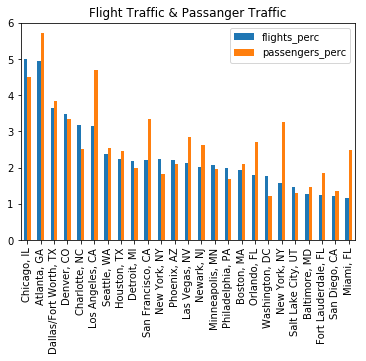

In [70]:
nvar=25
xlabel_list=df_airport_id.origin_city_name.values.tolist()[:nvar]
axes=df_airport_id[['flights_perc','passengers_perc']].iloc[:nvar,:].plot.bar()
axes.set_xticklabels((xlabel_list))
axes.set_title('Flight Traffic & Passanger Traffic')

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [73]:
df_flights.columns 

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [74]:
features_task10=['fl_date', 'mkt_unique_carrier', 'op_unique_carrier', 
       'dep_delay', 'arr_delay', 'flights', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay']

In [75]:
task10=df_flights[features_task10].copy()

In [77]:
task10.dtypes

fl_date                datetime64[ns]
mkt_unique_carrier             object
op_unique_carrier              object
dep_delay                     float64
arr_delay                     float64
flights                       float64
distance                      float64
carrier_delay                 float64
weather_delay                 float64
nas_delay                     float64
security_delay                float64
late_aircraft_delay           float64
dtype: object

In [109]:
task10[features_task10]=task10[features_task10].fillna(0,axis=1)
task10['month']=task10.fl_date.dt.month.astype(str).str.rjust(2,"0")
task10['total_delay']=task10[['dep_delay',"arr_delay","carrier_delay","weather_delay","nas_delay","security_delay","late_aircraft_delay"]].sum(axis=1)
task10.head()

,fl_date,mkt_unique_carrier,op_unique_carrier,dep_delay,arr_delay,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,month,total_delay
0,2019-08-24,UA,OO,0.0,-9.0,1.0,283.0,0.0,0.0,0.0,0.0,0.0,08,-9.0
1,2019-01-05,WN,WN,-3.0,-13.0,1.0,1020.0,0.0,0.0,0.0,0.0,0.0,01,-16.0
2,2018-05-18,WN,WN,21.0,13.0,1.0,1020.0,0.0,0.0,0.0,0.0,0.0,05,34.0
3,2018-08-27,DL,9E,-7.0,-16.0,1.0,726.0,0.0,0.0,0.0,0.0,0.0,08,-23.0
4,2019-05-29,DL,DL,21.0,11.0,1.0,1269.0,0.0,0.0,0.0,0.0,0.0,05,32.0


### #Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)


In [110]:
month_delay=pd.DataFrame(task10.groupby(['op_unique_carrier','month'])['total_delay'].mean())
month_delay

total_delay
op_unique_carrier month             
9E                01       17.847826
                  02       64.974138
                  03       13.427586
                  04      102.161972
                  05        9.364964
...                              ...
ZW                08       70.472222
                  09       18.461538
                  10        2.274510
                  11       21.907407
                  12        2.687500

[314 rows x 1 columns]

### Find out distance covered monthly by different air carriers

In [127]:
month_distance=pd.DataFrame(task10.groupby(['op_unique_carrier','month'])['distance'].sum())
month_distance.index.names=['carrier','month']
month_distance

distance
carrier month          
9E      01      44675.0
        02      61300.0
        03      61918.0
        04      66217.0
        05      63810.0
...                 ...
ZW      08      26143.0
        09      14600.0
        10      19456.0
        11      19060.0
        12      17987.0

[314 rows x 1 columns]

### Find out number of passengers that were carried by different air carriers

In [128]:
task10_passengers = pd.read_sql_query('SELECT carrier, unique_carrier_name, unique_carrier_name, month, passengers FROM passengers ORDER BY RANDOM() LIMIT 50000;', connection)
task10_passengers

,carrier,unique_carrier_name,unique_carrier_name,month,passengers
0,4B,Boutique Air,Boutique Air,11,8.0
1,G4,Allegiant Air,Allegiant Air,4,1200.0
2,DL,Delta Air Lines Inc.,Delta Air Lines Inc.,4,575.0
3,7S,Ryan Air f/k/a Arctic Transportation,Ryan Air f/k/a Arctic Transportation,8,0.0
4,1YQ,"Air Charter, Inc d/b/a Air Flamenco","Air Charter, Inc d/b/a Air Flamenco",2,0.0
...,...,...,...,...,...
49995,UA,United Air Lines Inc.,United Air Lines Inc.,10,9387.0
49996,FI,Icelandair,Icelandair,1,2172.0
49997,DL,Delta Air Lines Inc.,Delta Air Lines Inc.,4,5207.0
49998,AA,American Airlines Inc.,American Airlines Inc.,4,110.0


In [129]:
task10_passengers['month']=task10_passengers['month'].astype(str)
task10_passengers['month']=task10_passengers['month'].str.rjust(2,"0")
task10_passengers

,carrier,unique_carrier_name,unique_carrier_name,month,passengers
0,4B,Boutique Air,Boutique Air,11,8.0
1,G4,Allegiant Air,Allegiant Air,04,1200.0
2,DL,Delta Air Lines Inc.,Delta Air Lines Inc.,04,575.0
3,7S,Ryan Air f/k/a Arctic Transportation,Ryan Air f/k/a Arctic Transportation,08,0.0
4,1YQ,"Air Charter, Inc d/b/a Air Flamenco","Air Charter, Inc d/b/a Air Flamenco",02,0.0
...,...,...,...,...,...
49995,UA,United Air Lines Inc.,United Air Lines Inc.,10,9387.0
49996,FI,Icelandair,Icelandair,01,2172.0
49997,DL,Delta Air Lines Inc.,Delta Air Lines Inc.,04,5207.0
49998,AA,American Airlines Inc.,American Airlines Inc.,04,110.0


In [130]:
month_passanger=pd.DataFrame(task10_passengers.groupby(['carrier',"month"])['passengers'].sum())
month_passanger

passengers
carrier month            
02Q     01           52.0
        11           19.0
04Q     01          197.0
        02         1034.0
        03         1228.0
...                   ...
ZX      07        11739.0
        08        10678.0
        09        10759.0
        10        16772.0
        12         3714.0

[2707 rows x 1 columns]

### Find out total fuel comsumption per air carrier

In [131]:
#total fuel comsumption per air carrier
df_fuel = pd.read_sql_query('SELECT carrier, carrier_name,  month, total_gallons FROM fuel_comsumption ORDER BY RANDOM() LIMIT 50000;', connection)
df_fuel.head()

,carrier,carrier_name,month,total_gallons
0,OH,PSA Airlines Inc.,10,0.0
1,ZW,Air Wisconsin Airlines Corp,1,6016332.0
2,MQ,Envoy Air,8,0.0
3,F9,Frontier Airlines Inc.,5,24591649.0
4,PRQ,Florida West Airlines Inc.,2,0.0


In [161]:
df_fuel.carrier.unique()

array(['OH', 'ZW', 'MQ', 'F9', 'PRQ', 'NK', 'KD', 'PO', 'KAQ', 'X9', 'B6',
       'WI', 'GFQ', 'WN', 'L2', 'XP', '3EQ', '8C', 'EE', '1BQ', 'WP',
       'VX', 'SY', 'YV', '9E', '5V', '23Q', 'U7', 'DL', 'N8', '5Y', 'ABX',
       'EV', '5X', 'HA', 'M6', 'YX', 'AS', 'KLQ', '27Q', '9S', '0WQ',
       'CP', '2HQ', '09Q', 'PFQ', 'NC', 'G7', 'GL', 'G4', '0JQ', 'UA',
       'QX', 'OO', 'AA', 'MRQ', 'FX', 'K8', 'WE', 'WL', 'KH', 'S5', '16',
       'US', 'FCQ'], dtype=object)

In [132]:
df_fuel['month']=df_fuel['month'].astype(str)
df_fuel['month']=df_fuel['month'].str.rjust(2,"0")
df_fuel

,carrier,carrier_name,month,total_gallons
0,OH,PSA Airlines Inc.,10,0.0
1,ZW,Air Wisconsin Airlines Corp,01,6016332.0
2,MQ,Envoy Air,08,0.0
3,F9,Frontier Airlines Inc.,05,24591649.0
4,PRQ,Florida West Airlines Inc.,02,0.0
...,...,...,...,...
3030,YX,Republic Airlines,05,14720553.0
3031,0WQ,Avjet Corporation,02,0.0
3032,9S,Southern Air Inc.,09,5223428.0
3033,DL,Delta Air Lines Inc.,06,336183657.0


In [133]:
month_consuption=pd.DataFrame(df_fuel.groupby(['carrier',"month"])['total_gallons'].sum())
month_consuption

total_gallons
carrier month               
09Q     01         3055241.0
        02         3504322.0
        03         5150056.0
        04         2950101.0
        05         3072049.0
...                      ...
ZW      08        13492766.0
        09         6661501.0
        10         6824293.0
        11         6396823.0
        12         6624974.0

[756 rows x 1 columns]

### Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [134]:
print(month_delay.shape)
print(month_distance.shape)
print(month_passanger.shape)
print(month_consuption.shape)

(314, 1)
(314, 1)
(2707, 1)
(756, 1)


In [137]:
df_merged=pd.merge(month_delay,month_distance,right_index=True, left_index=True)
df_merged.head(20)

total_delay  distance
carrier month                       
9E      01       17.847826   44675.0
        02       64.974138   61300.0
        03       13.427586   61918.0
        04      102.161972   66217.0
        05        9.364964   63810.0
        06       51.598726   71134.0
        07       25.174242   61562.0
        08       38.242424   60574.0
        09       17.926829   55920.0
        10       13.133333   53918.0
        11       19.658120   53122.0
        12       21.755556   63554.0
9K      02        2.500000     185.0
        05      -19.000000     258.0
AA      01       21.042316  449004.0
        02       37.764967  466586.0
        03       23.197034  459524.0
        04       25.456967  483184.0
        05       41.438114  500568.0
        06       56.436293  535831.0

In [138]:
df_merged1=pd.merge(df_merged,month_passanger,right_index=True, left_index=True)
df_merged1.head(20)

total_delay  distance  passengers
carrier month                                   
9E      01       17.847826   44675.0     91145.0
        02       64.974138   61300.0     80263.0
        03       13.427586   61918.0    143789.0
        04      102.161972   66217.0    124107.0
        05        9.364964   63810.0    103730.0
        06       51.598726   71134.0    109940.0
        07       25.174242   61562.0    159737.0
        08       38.242424   60574.0    121782.0
        09       17.926829   55920.0    128609.0
        10       13.133333   53918.0    133338.0
        11       19.658120   53122.0    148192.0
        12       21.755556   63554.0    119164.0
9K      02        2.500000     185.0      6082.0
        05      -19.000000     258.0      4163.0
AA      01       21.042316  449004.0    999294.0
        02       37.764967  466586.0   1021163.0
        03       23.197034  459524.0   1342641.0
        04       25.456967  483184.0   1305431.0
        05       41.438114  500568.0   1240369.0
        06       56.436293  535831.0   1355708.0

In [139]:
df_task10=pd.merge(df_merged1,month_consuption,right_index=True, left_index=True)
df_task10.columns=['avg_dealy',"distance","passengers","total_gallons"]
df_task10['distance_km']=df_task10['distance']*1.609344
df_task10=df_task10[df_task10.total_gallons>0]
df_task10.head(20)


avg_dealy  distance  passengers  total_gallons    distance_km
carrier month                                                               
AA      01     21.042316  449004.0    999294.0   1.334803e+09  722601.893376
        02     37.764967  466586.0   1021163.0   1.222041e+09  750897.379584
        03     23.197034  459524.0   1342641.0   1.411525e+09  739532.192256
        04     25.456967  483184.0   1305431.0   1.378073e+09  777609.271296
        05     41.438114  500568.0   1240369.0   1.481394e+09  805586.107392
        06     56.436293  535831.0   1355708.0   1.517748e+09  862336.404864
        07     39.884892  567840.0   1534980.0   1.691431e+09  913849.896960
        08     53.530364  501344.0   1604295.0   1.658195e+09  806834.958336
        09     23.234592  499420.0   1194057.0   1.464153e+09  803738.580480
        10     17.387967  474307.0   1212198.0   1.202771e+09  763323.124608
        11     17.889362  452642.0   1233987.0   1.089813e+09  728456.686848
        12     26.229249  480144.0   1387367.0   1.182938e+09  772716.865536
AS      01     26.174312  157447.0    303283.0   2.269071e+08  253386.384768
        02     17.200000  151483.0    231954.0   2.069734e+08  243788.257152
        03      5.197183  181460.0    265421.0   2.413343e+08  292031.562240
        04     -3.161538  167667.0    232627.0   2.364655e+08  269833.880448
        05     10.661972  179368.0    388431.0   2.439073e+08  288664.814592
        06     23.071895  188681.0    307435.0   2.500881e+08  303652.635264
        07     10.392593  170272.0    284394.0   2.603468e+08  274026.221568
        08     23.934307  170479.0    330009.0   2.577697e+08  274359.355776

### get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?¶

In [140]:
df_task10['gallons_per_km']=df_task10.total_gallons/df_task10.distance_km
df_task10['gallons_per_km_per_pass']=df_task10.gallons_per_km/df_task10.passengers

In [141]:
task10_resp=df_task10[["avg_dealy","gallons_per_km_per_pass"]].copy()
task10_resp.columns=["avg_delay","gallons_per_km_per_pass"]
task10_resp=task10_resp.groupby(['carrier']).mean()
task10_resp

,avg_delay,gallons_per_km_per_pass
carrier,,
AA,31.957676,0.001386
AS,12.465712,0.003036
B6,52.448936,0.003280
DL,17.447477,0.001542
EV,42.071003,0.000026
F9,44.740101,0.005497
G4,32.168567,0.009018
HA,8.176615,0.028740
NK,32.398281,0.003552


Text(0.5,1,'Carrier Average(delay) [min]')

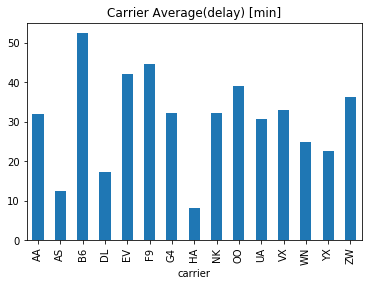

In [142]:
axes=task10_resp.avg_delay.plot.bar()
axes.set_title('Carrier Average(delay) [min]')

Text(0.5,1,'Carrier Average(Fuel Comsuption per 1km per 1passenger) [Gallons]')

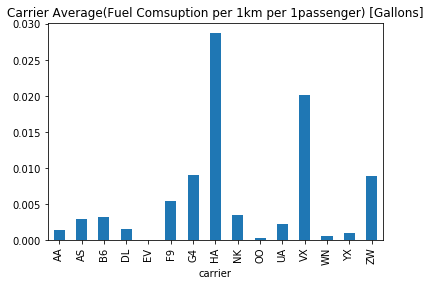

In [143]:
axes=task10_resp.gallons_per_km_per_pass.plot.bar()
axes.set_title('Carrier Average(Fuel Comsuption per 1km per 1passenger) [Gallons]')

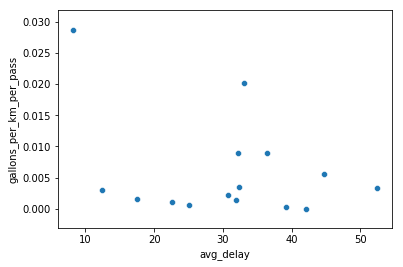

In [147]:
sns.scatterplot(data=task10_resp, x="avg_delay", y="gallons_per_km_per_pass")

In [148]:
task10_resp['index']=task10_resp.index.values
task10_resp

,avg_delay,gallons_per_km_per_pass,index
carrier,,,
AA,31.957676,0.001386,AA
AS,12.465712,0.003036,AS
B6,52.448936,0.003280,B6
DL,17.447477,0.001542,DL
EV,42.071003,0.000026,EV
F9,44.740101,0.005497,F9
G4,32.168567,0.009018,G4
HA,8.176615,0.028740,HA
NK,32.398281,0.003552,NK


Text(0.5,1,'Fuels Comsumption & Avg Delay')

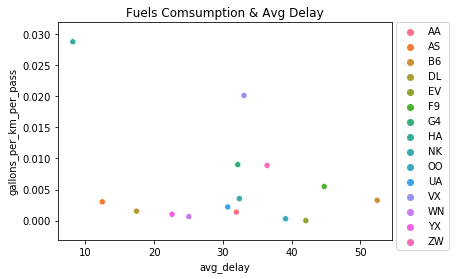

In [150]:
sns.scatterplot(data=task10_resp, x="avg_delay", y="gallons_per_km_per_pass",hue='index')
pl.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
pl.title('Fuels Comsumption & Avg Delay')